# Retrieval-Augmented Generation (RAG) Evaluation

- Framework: https://dspy-docs.vercel.app/
- VectorDB: https://github.com/chroma-core/chroma
- LLM: https://huggingface.co/mistralai/Mixtral-8x7B-Instruct-v0.1

In [1]:
import os

from dspy.retrieve.chromadb_rm import ChromadbRM
import chromadb
from chromadb.utils import embedding_functions
import dspy

from tqdm import tqdm
import json
import pickle
import pandas as pd


os.environ["DSP_NOTEBOOK_CACHEDIR"] = '/data01/alocaputo/.cache'

### Auxiliary functions

From: https://github.com/google-deepmind/ithaca/blob/ced13193aaa52e49a2388c9ace0244e9a24e6d42/ithaca/eval/inference.py

In [2]:
# Copyright 2021 the Ithaca Authors
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import jax
import re
import functools
import pickle

from absl import app
from absl import flags
from ithaca.eval import inference
from ithaca.models.model import Model
from ithaca.util.alphabet import GreekAlphabet

import ithaca.util.text as util_text
import numpy as np
import json
from tqdm import tqdm
import argparse
import os

MIN_TEXT_LEN = 50
TEXT_LEN = 768  # fixed model sequence length
DATE_MIN = -800
DATE_MAX = 800
DATE_INTERVAL = 10
RESTORATION_BEAM_WIDTH = 20
RESTORATION_TEMPERATURE = 1.
SEED = 1
ALPHABET_MISSING_RESTORE = '?'  # missing characters to restor


def prepare_text(text, alphabet):
  """Adds start of sequence symbol, and padding.

  Also strips accents if present, trims whitespace, and generates arrays ready
  for input into the model.

  Args:
    text: Raw text input string, no padding or start of sequence symbol.
    alphabet: GreekAlphabet object containing index/character mappings.

  Returns:
    Tuple of cleaned text (str), padded text (str), char indices (array of batch
    size 1), word indices (array of batch size 1), text length (list of size 1)
  """
  if type(text) == list:
    text = text[0]
  text = re.sub(r'\s+', ' ', text.strip())
  text = util_text.strip_accents(text)

  if len(text) < MIN_TEXT_LEN:
    raise ValueError('Input text too short.')

  if len(text) >= TEXT_LEN - 1:
    raise ValueError('Input text too long.')

  text_sos = alphabet.sos + text
  text_len = [len(text_sos)]  # includes SOS, but not padding

  text_padded = text_sos + alphabet.pad * max(0, TEXT_LEN - len(text_sos))

  restore_mask_idx = [
      i for i, c in enumerate(text_padded) if c == ALPHABET_MISSING_RESTORE
  ]
  text_padded = text_padded.replace(ALPHABET_MISSING_RESTORE, alphabet.missing)

  text_char = util_text.text_to_idx(text_padded, alphabet).reshape(1, -1)
  text_word = util_text.text_to_word_idx(text_padded, alphabet).reshape(1, -1)
  padding = np.where(text_char > 0, 1, 0)

  return (text, text_sos, text_padded, text_char, text_word, text_len, padding,
          restore_mask_idx)

from ithaca.util.alphabet import GreekAlphabet
def load_checkpoint(path):
  """Loads a checkpoint pickle.

  Args:
    path: path to checkpoint pickle

  Returns:
    a model config dictionary (arguments to the model's constructor), a dict of
    dicts containing region mapping information, a GreekAlphabet instance with
    indices and words populated from the checkpoint, a dict of Jax arrays
    `params`, and a `forward` function.
  """

  # Pickled checkpoint dict containing params and various config:
  with open(path, 'rb') as f:
    checkpoint = pickle.load(f)

  # We reconstruct the model using the same arguments as during training, which
  # are saved as a dict in the "model_config" key, and construct a `forward`
  # function of the form required by attribute() and restore().
  params = jax.device_put(checkpoint['params'])
  model = Model(**checkpoint['model_config'])
  forward = functools.partial(model.apply, params)

  # Contains the mapping between region IDs and names:
  region_map = checkpoint['region_map']

  # Use vocabulary mapping from the checkpoint, the rest of the values in the
  # class are fixed and constant e.g. the padding symbol
  alphabet = GreekAlphabet()
  alphabet.idx2word = checkpoint['alphabet']['idx2word']
  alphabet.word2idx = checkpoint['alphabet']['word2idx']

  return checkpoint['model_config'], region_map, alphabet, params, forward

def attribute(text, forward, params, alphabet, vocab_char_size, vocab_word_size, region_map):
  """Computes predicted date and geographical region."""
  (text, _, _, text_char, text_word, text_len, padding,
   _) = prepare_text(text, alphabet)

  rng = jax.random.PRNGKey(SEED)
  date_logits, subregion_logits, mask_logits, nsp_logits = forward(
      text_char=text_char,
      text_word=text_word,
      rngs={'dropout': rng},
      is_training=False)
    
  return mask_logits

Compute Ithaca's embeddings

In [3]:
def compute_emb(input_text, cuda_id):

    os.environ["CUDA_VISIBLE_DEVICES"] = cuda_id

    # if not 50 <= len(input_text) <= 750:
    #     continue

    (model_config, region_map, alphabet, params,
    forward) = load_checkpoint('../ithaca/checkpoint.pkl')
    vocab_char_size = model_config['vocab_char_size']
    vocab_word_size = model_config['vocab_word_size']
    mask_logits = attribute(
        input_text,
        forward=forward,
        params=params,
        alphabet=alphabet,
        region_map=region_map,
        vocab_char_size=vocab_char_size,
        vocab_word_size=vocab_word_size)

    return mask_logits[0].mean(axis=1).tolist()

## Data preparation

Ithaca's embedding function for chromaDB

In [4]:
from chromadb import Documents, EmbeddingFunction, Embeddings

class IthacaEmbeddingFunction(EmbeddingFunction):
    def __call__(self, input: Documents) -> Embeddings:
        return compute_emb(input, '0')

ithacaEF = IthacaEmbeddingFunction()

Store the trainset's embedding in ChromaDB.

The trainset contains only the archaic inscriptions.

In [5]:
# archaic_train and iphi_archaic_train

In [53]:
chroma_exist = True
collection_name = 'archaic_train'

chroma_client = chromadb.PersistentClient(path="data/chroma/iphi")
#chroma_client.delete_collection(name=file_name)

if chroma_exist:
    collection = chroma_client.get_collection(name=collection_name)
else:
    collection = chroma_client.create_collection(name=collection_name)


    dataset = json.load(open(f'data/archaic/train.json', 'r'))
    dataset_c = [ x for x in dataset if 50 <= len(x['text']) <= 750]

    #precomputed_embeddings = pickle.load(open(f'data/embeddings/ithaca/iphi_train.pkl', "rb"))

    for d in tqdm(dataset_c):
        phi_id = d['id']
        #try:
        #    emb = precomputed_embeddings[phi_id][0].mean(axis=1).tolist()
        #except:
        emb = ithacaEF(d['text'])
        text = d['text']

        metadata = str(d['metadata'])
        region_main_id = str(d['region_main_id'])
        region_main = str(d['region_main'])
        region_sub_id = str(d['region_sub_id'])
        region_sub = str(d['region_sub'])
        date_str = str(d['date_str'])
        date_min = str(d['date_min'])
        date_max = str(d['date_max'])
        date_circa = str(d['date_circa'])
        
        metadatas = {'metadata': metadata,
                    'region_main_id': region_main_id,
                    'region_main': region_main,
                    'region_sub_id': region_sub_id,
                    'region_sub': region_sub,
                    'date_str': date_str,
                    'date_min': date_min,
                    'date_max': date_max,
                    'date_circa': date_circa}
        collection.add(
        embeddings=emb,
        documents=[text],
        metadatas=[metadatas],
        ids=[str(phi_id)])

Load the trainset, testset and validation set for dspy

In [5]:
from dspy.datasets.dataset import Dataset

class IthacaDataset(Dataset):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        
        #df_train = pd.read_json('data/rag/iphi_train.json') # (ORIGINAL)
        # Use just archaic inscriptions but keep the same masking
        
        # df_train_iphi = pd.read_json('data/rag/iphi_train_rag.json')
        # df_train_archaic = pd.read_json('data/archaic/iphi_archaic_train.json') # NEW (MUST BE MASKED)

        # df_train = df_train_archaic.merge(
        # df_train_iphi[['id', 'masked_ag', 'masked_ithaca', 'masked_gt']],
        # on='id',
        # how='left'
        # )
        
        #df_train = df_train[['id', 'masked_gt', 'masked_ithaca']]
        #df_train.columns = ['id', 'answer', 'question'] 
        #self._train = df_train.to_dict(orient='records')

        df_test = pd.read_json('data/archaic/test_common.json')
        df_test = df_test[['id', 'dialect','masked_gt', 'masked_ithaca']]
        df_test.columns = ['id', 'dialect', 'answer', 'question']
        self._test = df_test.to_dict(orient='records')


class IthacaDatasetVal(Dataset):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)

        df_train = pd.read_json('data/archaic/validation_common.json')
        df_train = df_train[['id', 'dialect','masked_gt', 'masked_ithaca']]
        df_train.columns = ['id', 'dialect', 'answer', 'question']
        self._train = df_train.to_dict(orient='records')

dataset = IthacaDataset()

#trainset = [x.with_inputs('question') for x in dataset.train if len(x['question']) <= 750]
testset = [x.with_inputs('question') for x in dataset.test if len(x['question']) <= 750]

dataset_val = IthacaDatasetVal()
valset = [x.with_inputs('question') for x in dataset_val.train if len(x['question']) <= 750]

## Load the model

Using [Text Generation Inference](https://github.com/huggingface/text-generation-inference) to serve the LLM.

In [6]:
model_name = "mistralai/Mixtral-8x7B-Instruct-v0.1"

mixtral_llm = dspy.HFClientTGI(model = model_name, port=3000, url="http://158.110.146.233", **{"max_tokens": 25, 'seed': 0})

rm = ChromadbRM(collection_name='archaic_train', persist_directory="data/chroma/iphi", embedding_function=ithacaEF)
# rm = ChromadbRM(collection_name='iphi_archaic_train', persist_directory="data/chroma/iphi", embedding_function=ithacaEF)

dspy.settings.configure(lm=mixtral_llm, rm=rm)

In [7]:
class BasicRestorationNoContext(dspy.Signature):
    """You are given a fragmentary Greek inscription with missing text indicated by question marks. Your task is to fill in the missing characters of the inscription based on your understanding of ancient Greek language, grammar, and context.
    Do not replace characters that are not question marks"""

    inscription = dspy.InputField(desc='Every question mark corresponds to a missing character or a white space')
    restoration = dspy.OutputField(desc="The filled part of the text; It should be a sequence of Ancient Greek letters and possibly spaces; It must be between 1 and 10 characters long.")

In [8]:
class BasicRestoration(dspy.Signature):
    """You are given a fragmentary Greek inscription with missing text indicated by question marks. Your task is to fill in the missing characters of the inscription based on your understanding of ancient Greek language, grammar, and context.
    Do not replace characters that are not question marks"""

    inscription = dspy.InputField(desc='Every question mark corresponds to a missing character or a white space')
    context = dspy.InputField()
    restoration = dspy.OutputField(desc="The filled part of the text; It should be a sequence of Ancient Greek letters and possibly spaces; It must be between 1 and 10 characters long.")

In [9]:
class ZEROSHOT(dspy.Module):
    def __init__(self):
        super().__init__()
        self.generate_answer = dspy.Predict(BasicRestorationNoContext)
    
    def forward(self, question):
        inscription = question
        
        prediction = self.generate_answer(inscription=inscription)
        return dspy.Prediction(restoration=prediction.restoration)

In [10]:
class RAG(dspy.Module):
    def __init__(self, num_passages=3):
        super().__init__()

        self.retrieve = dspy.Retrieve(k=num_passages)
        self.generate_answer = dspy.Predict(BasicRestoration)
    
    def forward(self, question):
        inscription = question
        context = self.retrieve(inscription).passages

        prediction = self.generate_answer(context=context, inscription=inscription)
        return dspy.Prediction(context=context, restoration=prediction.restoration)

## Metrics

In [11]:
import editdistance


def edit_distance(example, pred, threshold=0.8, trace=None):
    """
    Compute the edit distance between the ground truth and the prediction and check if it is below a certain threshold.
    Output: True if the edit distance is below the threshold, False otherwise.
    """
    gt = example.answer.lower()
    pred = pred.restoration.lower()

    ed = editdistance.eval(pred, gt) / max(len(gt), len(pred))
    return ed <= threshold

def is_same_length(example, pred, trace=None):
    """
    Check if the length of the prediction is the same as the length of the ground truth.
    Output: True if the lengths are the same, False otherwise.
    """
    return example.question.count('?') == len(pred.restoration)

def exact_match(example, pred, trace=None):
    """
    Check if the prediction is exactly the same as the ground truth.
    Output: True if the prediction is exactly the same as the ground truth, False otherwise.
    """
    return example.answer.lower() == pred.restoration.lower()

def validate_lenght_and_cer(example, pred, trace=None):
    """
    Check if the length of the prediction is the same as the length of the ground truth and if the Character Error Rate (CER) is below a certain threshold.
    Output: True if the lengths are the same and the CER is below the threshold, False otherwise.
    """
    same_length = is_same_length(example, pred)
    edit_dist = edit_distance(example, pred, 0.8)
    return same_length and edit_dist 

## Evalutation

**Zeroshot**: Use the LLM to restore the inscription without providing additional information.

In [12]:
dialects = ['atticionic', 'doric', 'northwest', 'aeolic']
max_l = 30

In [13]:
def print_and_save_results(dialects, acc1, editd, max_l, name):
    for dialect in dialects:
        print(f"======== {dialect} ========")
        print(f'CER  : {np.mean([np.mean(v) for v in editd[dialect].values() if v])*100:.2f}%')
        print(f'ACC1 : {np.mean([np.mean(v) for v in acc1[dialect].values() if v])*100:.2f}%')

    print(f"======== TOTAL ========")
    cert = { x: [] for x in range(1, max_l+1)}
    for k, vs in editd.items():
        for kk, v in vs.items():
            cert[kk].extend(v)
    acc1t = { x: [] for x in range(1, max_l+1)}
    for k, vs in acc1.items():
        for kk, v in vs.items():
            acc1t[kk].extend(v)
            
    print(f'CER : {np.mean([np.mean(v) for v in cert.values() if v])*100:.2f}%')
    print(f'ACC1 : {np.mean([np.mean(v) for v in acc1t.values() if v])*100:.2f}%')

    # with open(f'{name}_editd.json', 'w') as f:
    #     json.dump(editd, f)

    # with open(f'{name}_acc1.json', 'w') as f:
    #     json.dump(acc1, f)

In [14]:
editd = { d: { x: [] for x in range(1, max_l+1)} for d in dialects}
acc1 = { d: { x: [] for x in range(1, max_l+1)} for d in dialects}
acc20 = { d: { x: [] for x in range(1, max_l+1)} for d in dialects}
correct_zs = []

zeroshot = ZEROSHOT()
answers = [ [] for x in testset]
for ll, example in enumerate(tqdm(testset)):
    
    pred = zeroshot.forward(question=example.question)

    gt = example.answer
    i = example.question.index('?')
    l = example.question.count('?')

    dialect = example.dialect
    
    ground_truth = example.answer.lower()
    text_prediction = pred.restoration.lower()
    
    ctop1 = 0
    if ground_truth == text_prediction:
        ctop1 = 1

    acc1[dialect][l].append(ctop1)
    #ed = editdistance.eval(text_prediction, ground_truth) / max(len(ground_truth), len(text_prediction))
    ed = editdistance.eval(text_prediction, ground_truth) / len(ground_truth)
    editd[dialect][l].append(ed)

    correct_zs.append((len(text_prediction), len(ground_truth)))

print_and_save_results(dialects, acc1, editd, max_l, "zeroshot")

100%|██████████| 95/95 [00:23<00:00,  3.98it/s]

======== atticionic ========
CER  : 235.89%
ACC1 : 0.00%
======== doric ========
CER  : 298.34%
ACC1 : 0.00%
======== northwest ========
CER  : 496.67%
ACC1 : 0.00%
======== aeolic ========
CER  : 160.83%
ACC1 : 0.00%
======== TOTAL ========
CER : 246.47%
ACC1 : 0.00%


In [15]:
editd = { d: { x: [] for x in range(1, max_l+1)} for d in dialects}
acc1 = { d: { x: [] for x in range(1, max_l+1)} for d in dialects}

correct_rag = []

rag = RAG()
answers = [ [] for x in testset]
for ll, example in enumerate(tqdm(testset)):
    pred = rag.forward(question=example.question)
    gt = example.answer
    i = example.question.index('?')
    l = example.question.count('?')

    dialect = example.dialect
    
    ground_truth = example.answer.lower()
    text_prediction = pred.restoration.lower()
    

    ctop1 = 0
    ctop20 = 0
    if ground_truth == text_prediction:
        ctop1 = 1

    #ed = editdistance.eval(text_prediction, ground_truth) / max(len(ground_truth), len(text_prediction))
    ed = editdistance.eval(text_prediction, ground_truth) / len(ground_truth)
    
    acc1[dialect][l].append(ctop1)
    editd[dialect][l].append(ed)
    correct_rag.append((len(text_prediction), len(ground_truth)))

print_and_save_results(dialects, acc1, editd, max_l, "rag")

100%|██████████| 95/95 [01:50<00:00,  1.16s/it]

======== atticionic ========
CER  : 162.67%
ACC1 : 8.60%
======== doric ========
CER  : 256.84%
ACC1 : 10.00%
======== northwest ========
CER  : 276.67%
ACC1 : 0.00%
======== aeolic ========
CER  : 105.83%
ACC1 : 0.00%
======== TOTAL ========
CER : 166.53%
ACC1 : 10.96%


In [16]:
from dspy.teleprompt import BootstrapFewShot

# Set up a basic teleprompter, which will compile our RAG program.
teleprompter = BootstrapFewShot(metric=validate_lenght_and_cer)

# Compile!
compiled_rag = teleprompter.compile(RAG(), trainset=valset) # was trainset

/data01/alocaputo/.cache/compiler


 80%|███████▉  | 70/88 [01:16<00:19,  1.10s/it]

Bootstrapped 4 full traces after 71 examples in round 0.


In [17]:
editd = { d: { x: [] for x in range(1, max_l+1)} for d in dialects}
acc1 = { d: { x: [] for x in range(1, max_l+1)} for d in dialects}
correct_ic = []

for example in tqdm(testset):
    pred = compiled_rag(question=example.question)
    gt = example.answer
    i = example.question.index('?')
    l = example.question.count('?')

    dialect = example.dialect
    
    ground_truth = example.answer.lower()
    text_prediction = pred.restoration.lower()

    ctop1 = 0
    ctop20 = 0
    if ground_truth == text_prediction:
        ctop1 = 1

    acc1[dialect][l].append(ctop1)
    #ed = editdistance.eval(text_prediction, ground_truth) / max(len(ground_truth), len(text_prediction))
    ed = editdistance.eval(text_prediction, ground_truth) / len(ground_truth)

    editd[dialect][l].append(ed)
    correct_ic.append((len(text_prediction), len(ground_truth)))

print_and_save_results(dialects, acc1, editd, max_l, "opt_rag")

100%|██████████| 95/95 [01:55<00:00,  1.22s/it]

======== atticionic ========
CER  : 146.92%
ACC1 : 11.62%
======== doric ========
CER  : 187.77%
ACC1 : 12.50%
======== northwest ========
CER  : 266.67%
ACC1 : 0.00%
======== aeolic ========
CER  : 113.33%
ACC1 : 0.00%
======== TOTAL ========
CER : 148.22%
ACC1 : 13.46%


In [18]:
from collections import Counter

def process_differences(differences):
    c = Counter(x[0] - x[1] for x in differences)
    cx = {k: v for k, v in c.items() if -10 < k < 10}
    cx['≥10'] = sum(v for k, v in c.items() if k >= 10)
    cx['≤10'] = sum(v for k, v in c.items() if k <= -10)
    return cx

zs_cx = process_differences(correct_zs)
rag_cx = process_differences(correct_rag)
ic_cx = process_differences(correct_ic)

/tmp/ipykernel_912011/907073884.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('tab20')


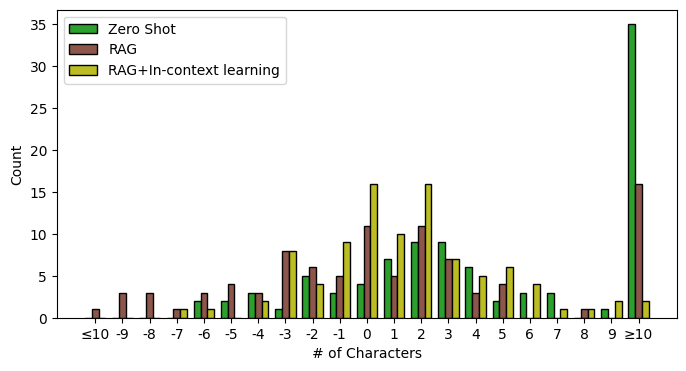

In [20]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm


bar_width = 0.25

keys = ['≤10'] + list(range(-9, 10)) + ['≥10']
zs_counts = [zs_cx.get(key, 0) for key in keys]
rag_counts = [rag_cx.get(key, 0) for key in keys]
ic_counts = [ic_cx.get(key, 0) for key in keys]

r1 = range(len(keys))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

plt.figure(figsize=(8, 4))
colormap = cm.get_cmap('tab20')

plt.bar(r1, zs_counts, color=colormap(0.2), width=bar_width, edgecolor='black', label='Zero Shot')
plt.bar(r2, rag_counts, color=colormap(0.5), width=bar_width, edgecolor='black', label='RAG')
plt.bar(r3, ic_counts, color=colormap(0.8), width=bar_width, edgecolor='black', label='RAG+In-context learning')

plt.xlabel('# of Characters')
plt.ylabel('Count')
#plt.title('Difference between prediction and ground truth length')
plt.xticks([r + bar_width for r in range(len(keys))], keys)
plt.legend()

plt.savefig('length_differences.pdf')
plt.show()